### CNN Model with VGG like architecture
Using data - > balanced dataset of 500 samples each - split 80-20 train and validation

Input size - 32 x 32 x 3

No further data augmentation 

Model used:

    1. Vgg like model -> conv-conv-pool-conv-conv-pool
    

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob #to walk through folder structure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#2 -> Filter out INFO & WARNING messages 
# tf.autograph.set_verbosity(1)

In [24]:
# !pip install hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [18]:
def generate_data(batch_size,img_height,img_width,train_dir,val_dir):

    batch_size = 16 #32
    img_height = 32 #128
    img_width = 32 #128


    train_dir = 'data/skinlesion_500_split_8020/train'
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    val_dir = 'data/skinlesion_500_split_8020/val'
    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    

    return train_ds,val_ds

In [38]:
batch_size =16
img_height =32
img_width =32
train_dir ='data/skinlesion_500_split_8020/train'
val_dir ='data/skinlesion_500_split_8020/val'
train_ds,val_ds = generate_data(batch_size,img_height,img_width,train_dir,val_dir)

Found 2800 files belonging to 7 classes.
Found 700 files belonging to 7 classes.


In [41]:
class_names = train_ds.class_names

In [42]:
## modified model-increasing dropout
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
    
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                        

In [43]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.0001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-12 21:47:28.910866: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 21:47:28.911202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 1.9126 - accuracy: 0.1936

2022-12-12 21:47:34.389142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 6s 32ms/step - loss: 1.9126 - accuracy: 0.1936 - val_loss: 1.9141 - val_accuracy: 0.1786
Epoch 2/50
175/175 [==============================] - 6s 31ms/step - loss: 1.8291 - accuracy: 0.2264 - val_loss: 1.8181 - val_accuracy: 0.2014
Epoch 3/50
175/175 [==============================] - 6s 32ms/step - loss: 1.8054 - accuracy: 0.2179 - val_loss: 1.8127 - val_accuracy: 0.2157
Epoch 4/50
175/175 [==============================] - 5s 30ms/step - loss: 1.7918 - accuracy: 0.2346 - val_loss: 1.7716 - val_accuracy: 0.2214
Epoch 5/50
175/175 [==============================] - 5s 30ms/step - loss: 1.7683 - accuracy: 0.2411 - val_loss: 1.7613 - val_accuracy: 0.2286
Epoch 6/50
175/175 [==============================] - 6s 32ms/step - loss: 1.7492 - accuracy: 0.2443 - val_loss: 1.7734 - val_accuracy: 0.2143
Epoch 7/50
175/175 [==============================] - 6s 32ms/step - loss: 1.7413 - accuracy: 0.2464 - val_loss: 1.7263 - val_accuracy: 0.2271
Epoch 8/50

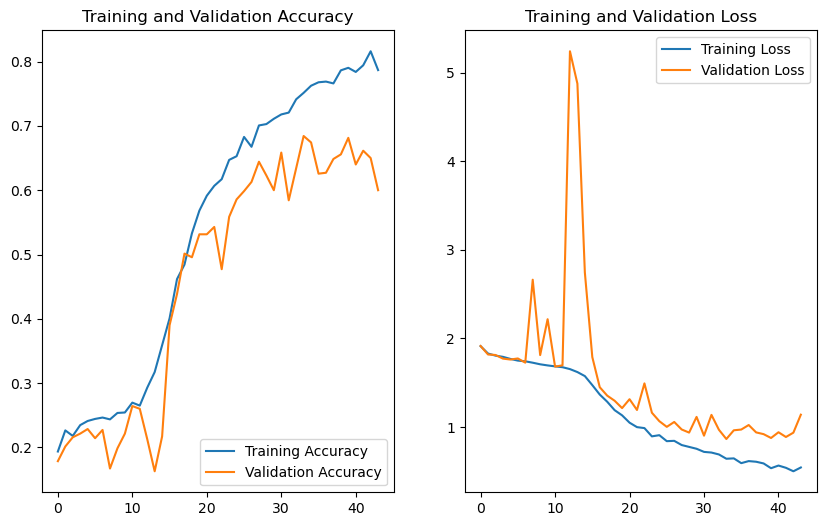

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(44)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
model.evaluate(val_ds)

44/44 [==============================] - 1s 16ms/step - loss: 1.1385 - accuracy: 0.6000


[1.1385053396224976, 0.5999999642372131]

In [51]:
extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 92/116
175/175 [==============================] - 6s 33ms/step - loss: 0.1703 - accuracy: 0.9393 - val_loss: 1.6397 - val_accuracy: 0.6643
Epoch 93/116
175/175 [==============================] - 6s 33ms/step - loss: 0.1767 - accuracy: 0.9400 - val_loss: 1.3356 - val_accuracy: 0.7029
Epoch 94/116
175/175 [==============================] - 6s 32ms/step - loss: 0.1812 - accuracy: 0.9282 - val_loss: 1.5250 - val_accuracy: 0.7171
Epoch 95/116
175/175 [==============================] - 6s 33ms/step - loss: 0.1693 - accuracy: 0.9382 - val_loss: 1.4664 - val_accuracy: 0.6957
Epoch 96/116
175/175 [==============================] - 6s 32ms/step - loss: 0.1608 - accuracy: 0.9411 - val_loss: 1.5126 - val_accuracy: 0.6729
Epoch 97/116
175/175 [==============================] - 6s 33ms/step - loss: 0.1925 - accuracy: 0.9282 - val_loss: 1.7263 - val_accuracy: 0.6614
Epoch 98/116
175/175 [==============================] - 6s 32ms/step - loss: 0.1484 - accuracy: 0.9429 - val_loss: 1.6463 - val_ac

In [52]:
model.evaluate(val_ds)

44/44 [==============================] - 1s 18ms/step - loss: 1.6001 - accuracy: 0.6871


[1.6001429557800293, 0.6871428489685059]

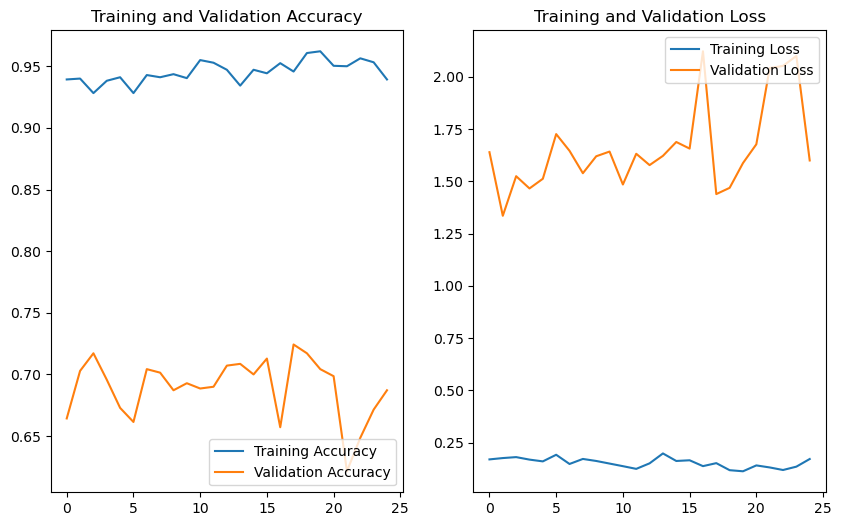

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()